# Mango Attribute Predict Model

### Imports

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython import get_ipython
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.optim as optim
import missingno as msno

### Data Preprocessing

In [31]:
df = pd.read_csv("../datathon-fme-mango/archive/product_data.csv")
attribute_data = pd.read_csv("../datathon-fme-mango/archive/attribute_data.csv")

In [32]:
df.head()

,cod_modelo_color,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,des_color
0,83_1124642,82,Female,Kids,KIDS,TRICOT,Tops,Sweaters and Cardigans,Sweater,Sweater,83_1124642_17074019-82_B.jpg,ROSA LIGHT
1,86_1215223,01,Female,Kids,KIDS,WOVEN,"Dresses, jumpsuits and Complete set",Dresses and jumpsuits,Dresses,Dress,86_1215223_47014392-01_B.jpg,BLANCO
2,84_1167695,70,Female,Kids,KIDS,CIRCULAR,Tops,T-shirts,T-shirt,T-Shirt,84_1167695_27005150-70_B.jpg,ROJO
3,82_1108473,01,Female,Teen,KIDS,JEANS,Bottoms,Jeans,Jeans,Jeans,82_1108473_87076320-01_B.jpg,BLANCO
4,83_1137778,37,Male,Adult,MAN,CIRCULAR,Tops,Sweaters and Cardigans,Sweatshirts,Sweatshirt,83_1137778_17014765-37_.jpg,KHAKI


In [33]:
df.describe()

,cod_modelo_color,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_filename,des_color
count,61484,61366,61484,61484,61484,61484,61484,61484,61484,61484,61484,61366
unique,33443,121,3,5,3,7,5,11,26,47,61484,121
top,83_1124642,99,Female,Adult,WOMAN,WOVEN,Tops,T-shirts,T-shirt,T-Shirt,83_1124642_17074019-82_B.jpg,NEGRO
freq,2,9755,43129,45905,33618,24336,28825,10291,9166,9166,1,9755


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61484 entries, 0 to 61483
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   cod_modelo_color               61484 non-null  object
 1   cod_color                      61366 non-null  object
 2   des_sex                        61484 non-null  object
 3   des_age                        61484 non-null  object
 4   des_line                       61484 non-null  object
 5   des_fabric                     61484 non-null  object
 6   des_product_category           61484 non-null  object
 7   des_product_aggregated_family  61484 non-null  object
 8   des_product_family             61484 non-null  object
 9   des_product_type               61484 non-null  object
 10  des_filename                   61484 non-null  object
 11  des_color                      61366 non-null  object
dtypes: object(12)
memory usage: 5.6+ MB


In [35]:
# Group by 'cod_modelo_color' and aggregate 'des_filename' into a list, keeping other columns
df = df.groupby('cod_modelo_color').agg({'des_filename': lambda x: list(x), **{col: 'first' for col in df.columns if col != 'cod_modelo_color' and col != 'des_filename'}}).reset_index()
#df = df.groupby('cod_modelo_color').agg({'des_filename': lambda x: list(x)}).reset_index()

# Display the updated dataframe
print(df.head())

  cod_modelo_color                                       des_filename  \
0       81_1034451  [81_1034451_77010000-99_B.jpg, 81_1034451_7701...   
1       81_1034525  [81_1034525_77030001-30_.jpg, 81_1034525_77030...   
2       81_1035318  [81_1035318_77004377-09_.jpg, 81_1035318_77004...   
3       81_1035321  [81_1035321_77004377-99_B.jpg, 81_1035321_7700...   
4       81_1035361  [81_1035361_77004378-69_B.jpg, 81_1035361_7700...   

  cod_color des_sex des_age des_line des_fabric des_product_category  \
0        99    Male   Adult      MAN      WOVEN                 Tops   
1        30    Male   Adult      MAN      WOVEN                 Tops   
2        09    Male   Adult      MAN      WOVEN            Outerwear   
3        99    Male   Adult      MAN      WOVEN            Outerwear   
4        69    Male   Adult      MAN      WOVEN            Outerwear   

  des_product_aggregated_family des_product_family des_product_type des_color  
0                        Shirts              Shi

In [36]:
df.head()

,cod_modelo_color,des_filename,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,des_product_type,des_color
0,81_1034451,"[81_1034451_77010000-99_B.jpg, 81_1034451_7701...",99,Male,Adult,MAN,WOVEN,Tops,Shirts,Shirt,Shirt,NEGRO
1,81_1034525,"[81_1034525_77030001-30_.jpg, 81_1034525_77030...",30,Male,Adult,MAN,WOVEN,Tops,Shirts,Shirt,Shirt,MARRON
2,81_1035318,"[81_1035318_77004377-09_.jpg, 81_1035318_77004...",09,Male,Adult,MAN,WOVEN,Outerwear,Jackets and Blazers,Jackets,Jacket,CAMEL
3,81_1035321,"[81_1035321_77004377-99_B.jpg, 81_1035321_7700...",99,Male,Adult,MAN,WOVEN,Outerwear,Jackets and Blazers,Jackets,Jacket,NEGRO
4,81_1035361,"[81_1035361_77004378-69_B.jpg, 81_1035361_7700...",69,Male,Adult,MAN,WOVEN,Outerwear,Jackets and Blazers,Jackets,Jacket,MARINO


In [37]:
#df.describe()

In [38]:
# Pivot the attribute_data dataframe
attribute_pivot = attribute_data.pivot(index='cod_modelo_color', columns='attribute_name', values='des_value')

# Reset the index to merge with df
attribute_pivot.reset_index(inplace=True)

# Merge the pivoted attribute data with the product data
df = pd.merge(df, attribute_pivot, on='cod_modelo_color', how='left')

# Display the merged dataframe
print(df.head())

  cod_modelo_color                                       des_filename  \
0       81_1034451  [81_1034451_77010000-99_B.jpg, 81_1034451_7701...   
1       81_1034525  [81_1034525_77030001-30_.jpg, 81_1034525_77030...   
2       81_1035318  [81_1035318_77004377-09_.jpg, 81_1035318_77004...   
3       81_1035321  [81_1035321_77004377-99_B.jpg, 81_1035321_7700...   
4       81_1035361  [81_1035361_77004378-69_B.jpg, 81_1035361_7700...   

  cod_color des_sex des_age des_line des_fabric des_product_category  \
0        99    Male   Adult      MAN      WOVEN                 Tops   
1        30    Male   Adult      MAN      WOVEN                 Tops   
2        09    Male   Adult      MAN      WOVEN            Outerwear   
3        99    Male   Adult      MAN      WOVEN            Outerwear   
4        69    Male   Adult      MAN      WOVEN            Outerwear   

  des_product_aggregated_family des_product_family  ... closure_placement  \
0                        Shirts              Shirt 

cod_modelo_color                     0
des_filename                         0
cod_color                           67
des_sex                              0
des_age                              0
des_line                             0
des_fabric                           0
des_product_category                 0
des_product_aggregated_family        0
des_product_family                   0
des_product_type                     0
des_color                           67
cane_height_type                 33186
closure_placement                18266
heel_shape_type                  32288
knit_structure                   28329
length_type                       5335
neck_lapel_type                  11892
silhouette_type                   4959
sleeve_length_type               11898
toecap_type                      32392
waist_type                       26579
woven_structure                  11637
dtype: int64


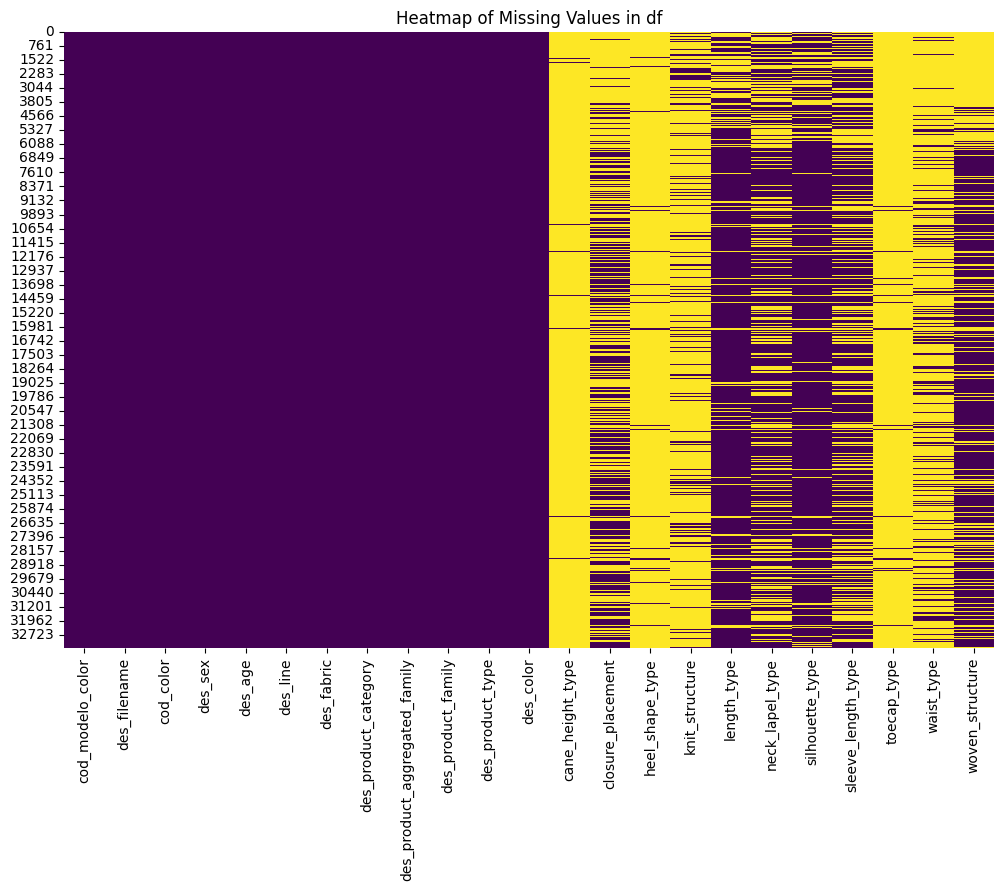

In [39]:
# Check for missing values in the dataframe
missing_values = df.isnull().sum()
print(missing_values)
# Create a heatmap of the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values in df')
plt.show()

In [40]:
# Select the categorical columns to encode
categorical_columns = ['cod_color', 'des_sex', 'des_age', 'des_line', 'des_fabric', 'des_product_category', 'des_product_aggregated_family', 'des_product_family', 'des_product_type', 'des_color', 'cane_height_type', 'closure_placement', 'heel_shape_type', 'knit_structure', 'length_type', 'neck_lapel_type', 'silhouette_type', 'sleeve_length_type', 'toecap_type', 'waist_type', 'woven_structure']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

df_encoded = df.copy()

# Loop through each categorical column
for col in categorical_columns:
    # Fit and transform the current column
    encoded_columns = encoder.fit_transform(df[[col]])
    
    # Replace the original column with the array of encoded values
    df_encoded[col] = list(encoded_columns)  # Each row will contain an array of 0s and 1s

# Display the updated dataframe
df_encoded.head()

,cod_modelo_color,des_filename,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,des_product_family,...,closure_placement,heel_shape_type,knit_structure,length_type,neck_lapel_type,silhouette_type,sleeve_length_type,toecap_type,waist_type,woven_structure
0,81_1034451,"[81_1034451_77010000-99_B.jpg, 81_1034451_7701...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
1,81_1034525,"[81_1034525_77030001-30_.jpg, 81_1034525_77030...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
2,81_1035318,"[81_1035318_77004377-09_.jpg, 81_1035318_77004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
3,81_1035321,"[81_1035321_77004377-99_B.jpg, 81_1035321_7700...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
4,81_1035361,"[81_1035361_77004378-69_B.jpg, 81_1035361_7700...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 

In [41]:
embeddings = pd.read_csv("../datathon-fme-mango/archive/256DimensionalEmbedding.csv") # CAMBIAR ENLACE CSV

# Assuming the 64 columns are named 'embedding_1', 'embedding_2', ..., 'embedding_64'
embedding_columns = [f'embeddings_{i}' for i in range(1, 65)]

# Combine the 64 columns into a single column
embeddings['embeddings'] = embeddings[embedding_columns].values.tolist()

# Drop the original 64 columns from embeddings dataframe
embeddings.drop(columns=embedding_columns, inplace=True)

# Display the updated embeddings dataframe
embeddings.head()

,embeddings_65,embeddings_66,embeddings_67,embeddings_68,embeddings_69,embeddings_70,embeddings_71,embeddings_72,embeddings_73,embeddings_74,...,embeddings_249,embeddings_250,embeddings_251,embeddings_252,embeddings_253,embeddings_254,embeddings_255,embeddings_256,filename,embeddings
0,-0.698616,-1.401896,-0.072824,0.911387,0.494490,-0.360804,-1.334807,0.811374,-0.738226,1.531781,...,-0.197801,-0.674908,-0.235033,-0.071141,-0.182178,-0.417165,-0.279902,0.014871,83_1124794_17001131-56_.jpg,"[-10.407478424520308, -3.264792558354129, -0.8..."
1,-1.267481,-0.076155,-0.038378,-0.884301,0.852288,-0.571832,0.365894,-0.903199,-0.668766,-0.798499,...,-0.285357,0.105511,0.593718,0.309956,-0.194992,-0.322730,0.389554,-0.211341,88_49720760_67060683-05_.jpg,"[0.1562782774227816, 5.0548436891239, 12.70501..."
2,0.763789,-0.179960,0.407324,0.283461,-1.805835,0.043042,-0.139188,0.643606,0.764285,0.600163,...,-0.036702,-0.641998,0.886061,-0.431066,0.036655,-0.061029,-0.339848,0.106872,82_1118361_87077646-41_B.jpg,"[11.822911805103963, -4.529342033021445, -4.48..."
3,1.856224,0.412092,-0.707516,1.867442,0.657091,0.733234,1.313426,-0.538186,0.568933,-1.614247,...,-0.542554,0.360742,-0.379048,-0.117083,-0.162719,0.072596,-0.149196,-0.098580,84_1183038_27055806-99_.jpg,"[-12.107448922823316, -0.2387411452851503, 0.6..."
4,-4.290869,-0.535302,-2.536398,-0.706627,0.659590,-1.025532,-0.520390,-0.458118,-1.510934,0.715984,...,-0.499204,-0.142772,0.756726,-0.390179,0.599636,0.133346,0.030094,-0.336109,84_1190357_27038646-99_B.jpg,"[6.680558185617, -5.666590531183909, -10.42178..."


In [42]:
# Explode the des_filename column to have one filename per row
df_exploded = df_encoded.explode('des_filename')

# Merge the exploded dataframe with the embeddings dataframe on the filename column
df_with_embeddings = pd.merge(df_exploded, embeddings, left_on='des_filename', right_on='filename', how='left')

# Group by 'cod_modelo_color' and aggregate the embeddings into a list
df_with_embeddings = df_with_embeddings.groupby('cod_modelo_color').agg({'des_filename': lambda x: list(x), 'embeddings': lambda x: list(x), **{col: 'first' for col in df.columns if col != 'cod_modelo_color' and col != 'des_filename'}}).reset_index()

# Display the updated dataframe
df_with_embeddings.head()

,cod_modelo_color,des_filename,embeddings,cod_color,des_sex,des_age,des_line,des_fabric,des_product_category,des_product_aggregated_family,...,closure_placement,heel_shape_type,knit_structure,length_type,neck_lapel_type,silhouette_type,sleeve_length_type,toecap_type,waist_type,woven_structure
0,81_1034451,"[81_1034451_77010000-99_B.jpg, 81_1034451_7701...","[[13.016323992584754, -6.276200547956117, 6.89...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
1,81_1034525,"[81_1034525_77030001-30_.jpg, 81_1034525_77030...","[[-7.995817681107588, -3.905868309711707, 6.20...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
2,81_1035318,"[81_1035318_77004377-09_.jpg, 81_1035318_77004...","[[-11.206977781589352, 5.0040516543254725, 6.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
3,81_1035321,"[81_1035321_77004377-99_B.jpg, 81_1035321_7700...","[[8.16622313864773, 8.238100408728622, 7.12912...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]"
4,81_1035361,"[81_1035361_77004378-69_B.jpg, 81_1035361_7700...","[[5.5098090440954435, 5.817874328147296, 5.420...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0